In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from object_detection.utils import label_map_util


In [2]:
model_name = 'ssd_mobilenet_v1' # ssd_mobilenet_v1, faster_rcnn_resnet50, faster_rcnn_resnet_101, ssd_inception_v2
model_filename ='/work/data/faces/frozen_inference_graph.pb'.format(model_name)


# model_filename ='/work/data/trafficsigns/ssd_inception_v2/inference_graph/frozen_inference_graph.pb'



# detector_name = 'ssd_mobilenet_v1'

dataset_name = 'faces'


with tf.compat.v1.gfile.GFile(model_filename, 'rb') as f:
    graph_def = tf.compat.v1.GraphDef()
    graph_def.ParseFromString(f.read())
with tf.Graph().as_default() as graph:
    tf.import_graph_def(graph_def, name='')


# model = tf.saved_model.load(model_filename)
# graph = model.signatures["serving_default"].graph

## Visualize Weights

In [3]:
from tensorflow.python.framework import tensor_util

weight_nodes =[n for n in graph_def.node if n.name.find("weight") >= 0 and n.op != "Identity"]

weight_mats = {}
total_sum_3x3 = np.zeros([3, 3])
total_sum_1x1 = 0
for node in weight_nodes:
    weights = tensor_util.MakeNdarray(node.attr['value'].tensor)
    if (len(weights.shape)) == 4:
        key = node.name[:-8]
        weight_mats[key] = np.sum(weights, (2, 3))
        if len(weights) == 3:
            total_sum_3x3 += weight_mats[key]
        else:
            total_sum_1x1 += weight_mats[key]

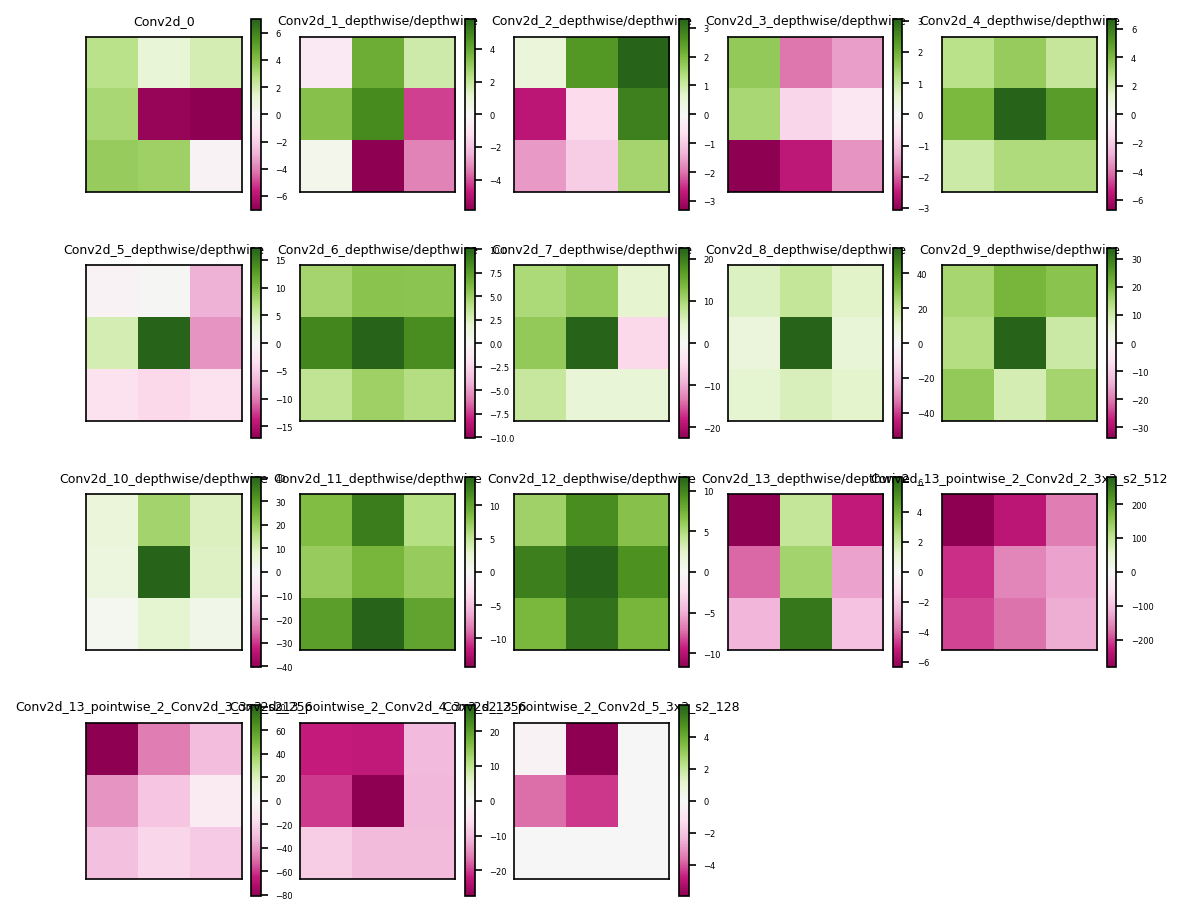

In [6]:
fig = plt.figure(figsize=(7, 20), dpi=150)
# fig.suptitle("classifier out map per class", fontsize=12)
plt.subplots_adjust(left=0, bottom=0.1, right=1, top=0.85, wspace=0.1, hspace=0.2)
ind = 0
for key in weight_mats:
    if len(weight_mats[key])== 1:
        continue
    ax = fig.add_subplot(len(weight_mats) / 5 + 1, 5, ind + 1)
    ax.set_title("{}".format(key[29:]), fontsize=6)

    vmin = np.min(weight_mats[key])
    vmax = np.max(weight_mats[key])
    max_abs = max(np.abs(vmin), np.abs(vmax))

    plt.imshow(weight_mats[key], vmin=-max_abs, vmax =max_abs, cmap=plt.get_cmap('PiYG'))


    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=4) 
    ax.grid(b=False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ind += 1


## Feature Maps

In [117]:
fe_tensors=[n.name + ":0" for n in graph_def.node if n.op.find("Conv2D") >= 0]
fe_tensors

with graph.as_default():
  with tf.compat.v1.Session() as sess:
    feed_dict={"image_tensor:0":np.random.rand(20, 512, 512, 3) * 256}
    fe_outputs = sess.run(fe_tensors, feed_dict)


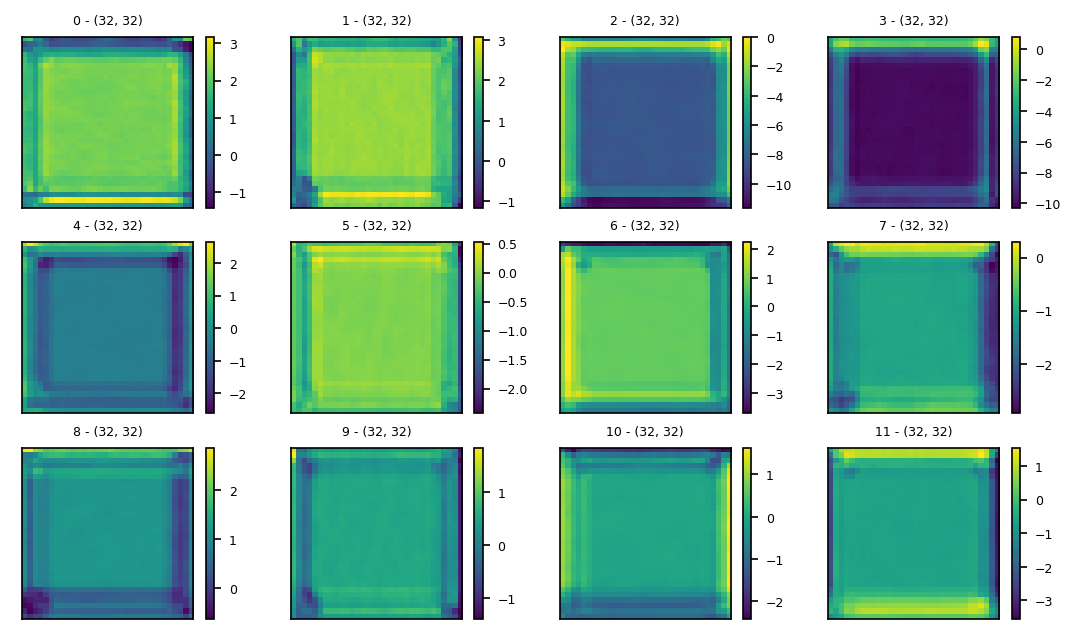

In [130]:
fig = plt.figure(figsize=(7,7), dpi=150)
plt.subplots_adjust(left=0, bottom=0.1, right=1, top=0.85, wspace=0.1, hspace=0.2)
ind = 0
for key in range(12):
    ax = fig.add_subplot(int(num_of_maps / 4) + 1, 4, ind + 1)
    avg_feat_map = np.mean(fe_outputs[0][:, :, :, ind], axis = 0)
 #   ax.set_title(ind)
    ax.set_title("{} - {}".format(ind, avg_feat_map.shape), fontsize=6)
    plt.imshow(avg_feat_map)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=6) 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ind += 1 

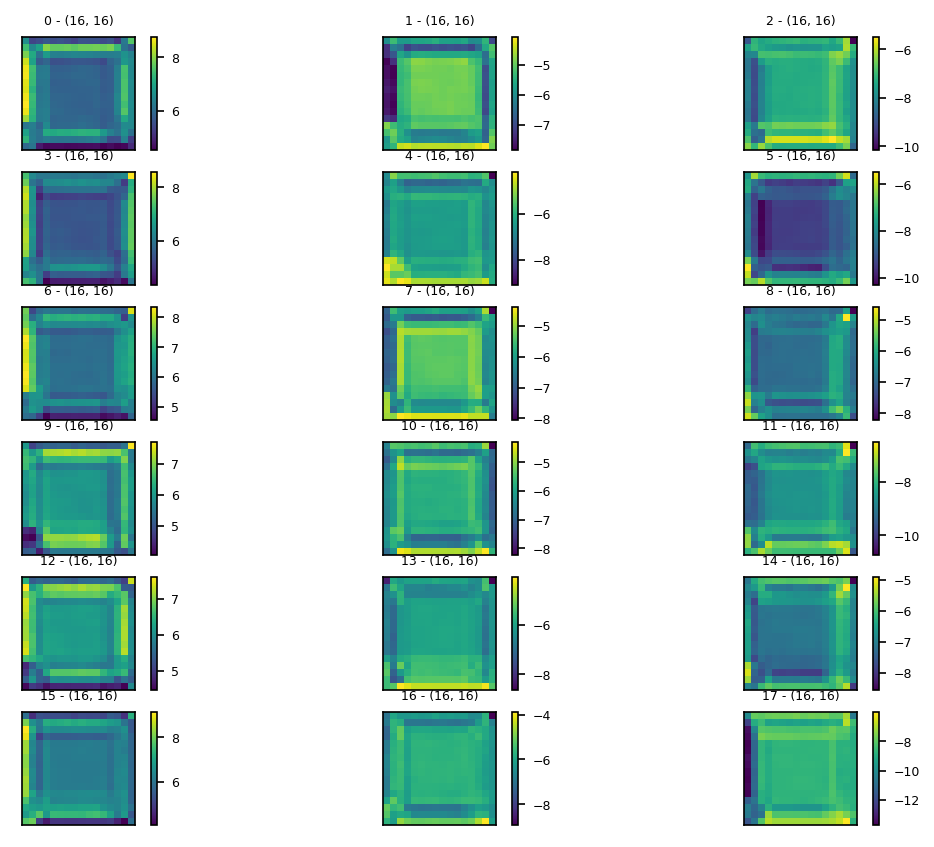

In [135]:
fig = plt.figure(figsize=(7,7), dpi=150)
plt.subplots_adjust(left=0, bottom=0.1, right=1, top=0.85, wspace=0.1, hspace=0.2)
ind = 0
for key in range(18):
    ax = fig.add_subplot(6, 3, ind + 1)
    avg_feat_map = np.mean(fe_outputs[3][:, :, :, ind], axis = 0)
 #   ax.set_title(ind)
    ax.set_title("{} - {}".format(ind, avg_feat_map.shape), fontsize=6)
    plt.imshow(avg_feat_map)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=6) 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ind += 1 

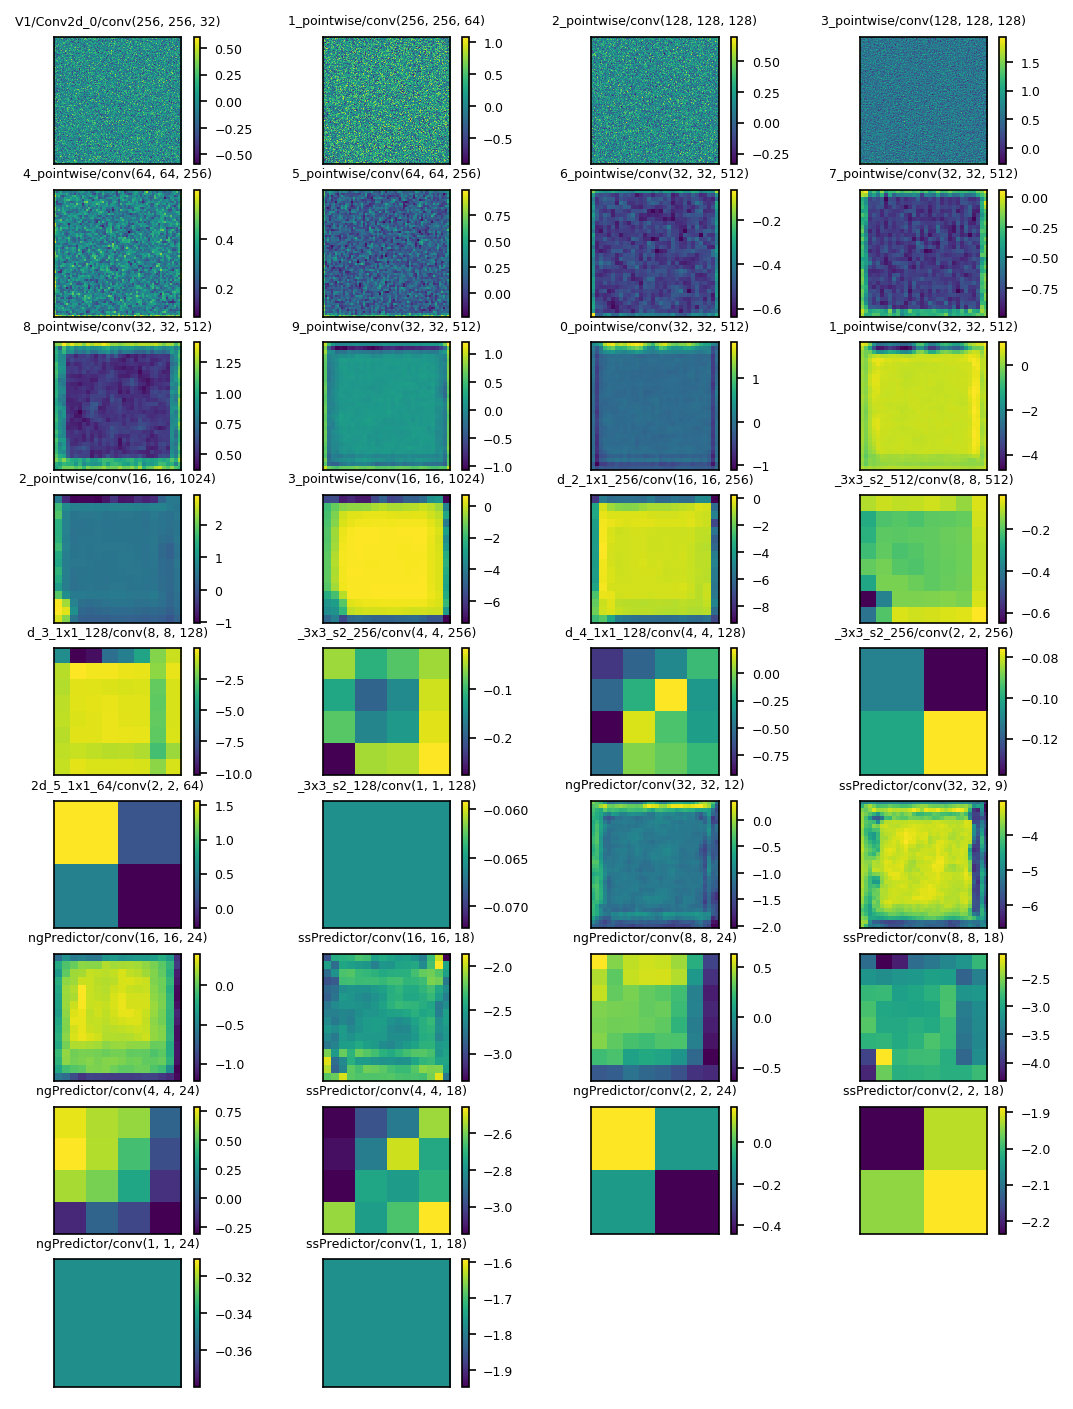

In [122]:
num_of_maps = len(fe_tensors)
fig = plt.figure(figsize=(7,12), dpi=150)
plt.subplots_adjust(left=0, bottom=0.1, right=1, top=0.85, wspace=0.1, hspace=0.2)
ind = 0
for key in range(num_of_maps):
    ax = fig.add_subplot(int(num_of_maps / 4) + 1, 4, ind + 1)
    avg_feat_map = np.mean(fe_outputs[ind][0], axis=2)
 #   ax.set_title(ind)
    ax.set_title(fe_tensors[ind][-25:-9] + "{}".format(fe_outputs[ind][0].shape), fontsize=6)
    plt.imshow(avg_feat_map)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=6) 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ind += 1


## Bias Maps

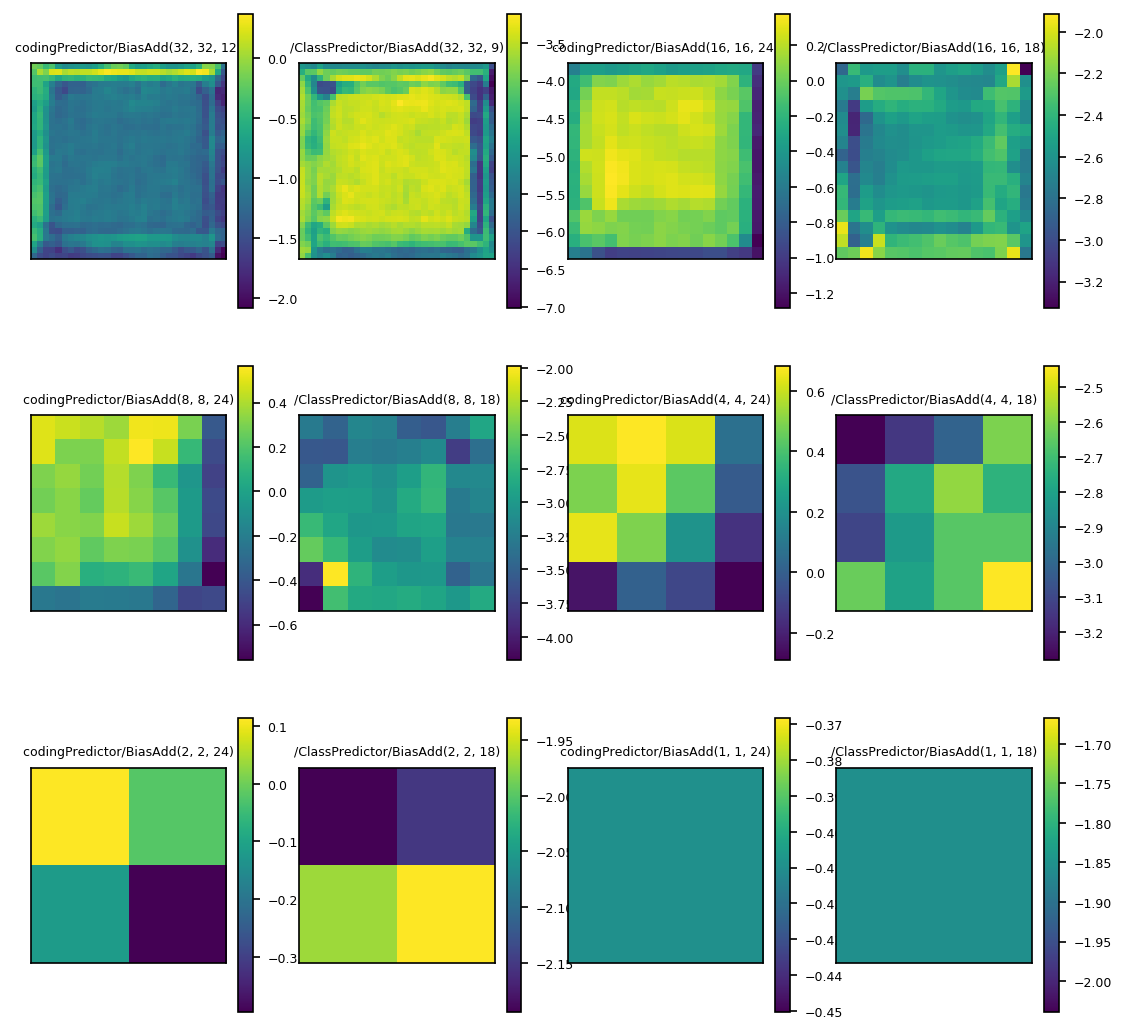

In [138]:
num_of_maps = len(fe_tensors)
fig = plt.figure(figsize=(7,12), dpi=150)
plt.subplots_adjust(left=0, bottom=0.1, right=1, top=0.85, wspace=0.1, hspace=0.2)
ind = 0
for key in range(num_of_maps):
    ax = fig.add_subplot(int(num_of_maps / 4) + 1, 4, ind + 1)
    avg_feat_map = np.mean(fe_outputs[ind][0], axis=2)
 #   ax.set_title(ind)
    ax.set_title(fe_tensors[ind][-25:-2] + "{}".format(fe_outputs[ind][0].shape), fontsize=6)
    plt.imshow(avg_feat_map)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=6) 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ind += 1




## Test on Images

In [32]:
from PIL import Image
img = Image.open("/work/data/faces/000001.jpg").convert("RGB")



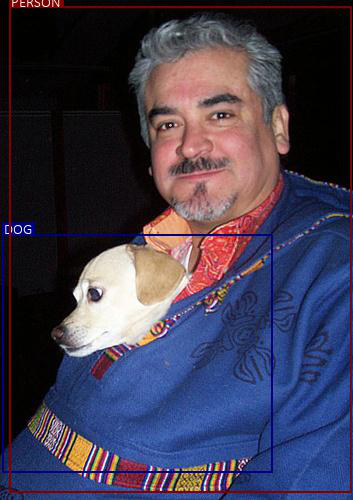

In [33]:
img

In [67]:
with graph.as_default():
  with tf.compat.v1.Session() as sess:
    feed_dict={"image_tensor:0":img} # np.expand_dims(img, 0)
    tensor_dict = {}
    for key in ['num_detections', 'detection_boxes', 'detection_scores', 'detection_classes']:
      tensor_name = key + ':0'
      tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
    det_outputs = sess.run(tensor_dict, feed_dict)





In [52]:
overlay = img.crop([130, 10, 300, 230]).resize([40, 50])

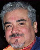

In [90]:
overlay

In [105]:
img = np.zeros([1, 1200, 1200, 3])

In [106]:
img[0][200:200 + overlay.size[1], 200:200 + overlay.size[0], :] = np.array(overlay)

## Visualizing Blind Spots

In [80]:
def calculate_iou(box_x, box_y, box_width, box_height, ins_x, ins_y, ins_width, ins_height):

    xA = max(box_x, ins_x)
    yA = max(box_y, ins_y)
    xB = min(box_x + box_width, ins_x + ins_width)
    yB = min(box_y + box_height, ins_y + ins_height)

    # if (ins_x == 0 and ins_y==0):
    #     print(box_x, box_y, box_width, box_height, ins_x, ins_y, ins_width, ins_height)
    #     print(xB-xA, yB-yA)

    interArea = max(xB-xA, 0.0) * max(yB-yA,0.0)
    unionArea = box_width * box_height + ins_width * ins_height - interArea
    return interArea / float(unionArea)

In [98]:
def calc_map(sess, src_img, obj_rect, x_step, y_step, debias = False, print_progress = False):

    obj_width = obj_rect[3] - obj_rect[1] + 1
    obj_height = obj_rect[2] - obj_rect[0] + 1

    scoremap_steps = np.zeros([src_img.shape[0], src_img.shape[1]])
    scoremap_unfiltered = np.zeros([src_img.shape[0], src_img.shape[1]])

    image = np.zeros([1, src_img.shape[0], src_img.shape[1], src_img.shape[2]])

    for startY in range(0, src_img.shape[0] - y_step+1, y_step):
      for startX in range(0, src_img.shape[1] - x_step+1, x_step):
        
        src_x1 = max(obj_rect[1] - startX, 0)
        src_x2 = src_img.shape[1] -  max(startX -  obj_rect[1], 0)

        src_y1 = max(obj_rect[0] - startY, 0)
        src_y2 = src_img.shape[0] -  max(startY -  obj_rect[0], 0)

        dest_x1 = max(startX - obj_rect[1], 0)
        dest_x2 = src_img.shape[1] -  max(obj_rect[1] - startX, 0)

        dest_y1 = max(startY - obj_rect[0], 0)
        dest_y2 = src_img.shape[0] -  max(obj_rect[0] - startY, 0)

        image[0, dest_y1:dest_y2, dest_x1:dest_x2, :] = src_img[src_y1:src_y2, src_x1:src_x2, :]
        
        feed_dict={"image_tensor:0":image} # np.expand_dims(img, 0)
        tensor_dict = {}
        for key in ['num_detections', 'detection_boxes', 'detection_scores', 'detection_classes']:
          tensor_name = key + ':0'
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
        output_dict = sess.run(tensor_dict, feed_dict)


        image[0, dest_y1:dest_y2, dest_x1:dest_x2, :] = 0


        boxes = output_dict['detection_boxes'][0]
        scores = output_dict['detection_scores'][0]
        best_iou = 0
        best_score = 0
        matched_iou = 0
        best_box = [0, 0, 0, 0]
        for i in range(len(boxes)):
            top = int(boxes[i][0] * src_img.shape[0])- 3 
            bottom = int(boxes[i][2] * src_img.shape[0]) + 3 
            left = int(boxes[i][1] * src_img.shape[1]) - 3 
            right = int(boxes[i][3] * src_img.shape[1]) + 3 

            iou = calculate_iou(left, top, right-left + 1, bottom - top + 1, 
                    startX - 3, startY - 3, obj_width + 7, obj_height + 7)
            if iou > 0.1:
                best_iou= max(best_iou, iou)
                if best_score < scores[i]:
                    matched_iou = iou
                    best_score = scores[i]
                    best_box = boxes[i]


        scoremap_steps[startY:startY + y_step, startX:startX + x_step] = best_score

        scoremap_unfiltered[startY:startY + y_step, startX:startX + x_step] = scores[0]

        if print_progress:
            print("{} - {}: {} in {}".format(startX, startY, best_score, best_box))

    return scoremap_steps, scoremap_unfiltered


In [107]:
with graph.as_default():
  with tf.compat.v1.Session() as sess:
    res_map = calc_map(sess, img[0], [200, 200, 250, 240], 25, 25)

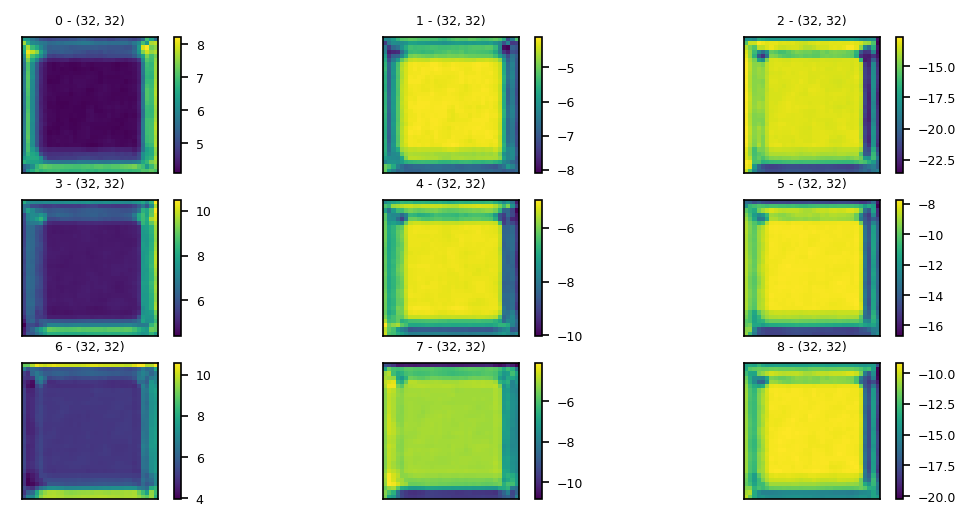

In [132]:
fig = plt.figure(figsize=(7,7), dpi=150)
plt.subplots_adjust(left=0, bottom=0.1, right=1, top=0.85, wspace=0.1, hspace=0.2)
ind = 0
for key in range(9):
    ax = fig.add_subplot(int(num_of_maps / 3) + 1, 3, ind + 1)
    avg_feat_map = np.mean(fe_outputs[1][:, :, :, ind], axis = 0)
 #   ax.set_title(ind)
    ax.set_title("{} - {}".format(ind, avg_feat_map.shape), fontsize=6)
    plt.imshow(avg_feat_map)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=6) 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ind += 1 

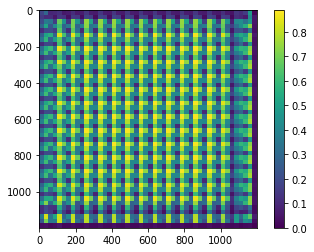

In [108]:
plt.imshow(res_map[0])
plt.colorbar()

The blue bands around 1050 on both x-axis and y-axis correspond to blind spots for the face detector